<h2> Infrastructure </h2>

In [1]:
# Created by Shawn
# Tests odds and ends more related to general python funtionality, interfacing with meters, etc. Want to store
# Most of the infrastructure is taken from the PMOS_LDO code on 5/26/25
import pyvisa                    # Instrument communication
import time                      # Handle time-related tasks (e.g., delays)
import matplotlib.pyplot as plt  # Plotting graphs and visualizing data
import numpy as np               # Numerical operations, particularly with arrays
import pandas as pd              # Data manipulation and analysis
import os                        # Interact with the operating system, such as handling file paths
import csv                       # Read from and write to CSV files
from datetime import date        # Read current date
from collections import defaultdict

In [2]:
# Determine the appropriate scaling for generated plots in Engineering Notation
def scale(list):
    array = np.asarray(list, dtype='float') # Python's lists don't support multiplication by a float. Numpy's arrays do.
    if np.max(np.abs(array)) < 1e-9:
        k = 1e12
    elif np.max(np.abs(array)) < 1e-6:
        k = 1e9
    elif np.max(np.abs(array)) < 1e-3:
        k = 1e6
    elif np.max(np.abs(array)) < 1:
        k = 1e3
    else:
        k = 1
    
    return k*array # Return the scaled array

# Determine the appropriate prefix for arrays that use scale(). 
# PASS THE ORIGINAL LIST, NOT THE SCALED
def prefix(list):
    array = np.asarray(list, dtype='float')
    if np.max(np.abs(array)) < 1e-9:
        k = 1e12
        prefix = 'p'
    elif np.max(np.abs(array)) < 1e-6:
        k = 1e9
        prefix = 'n'
    elif np.max(np.abs(array)) < 1e-3:
        k = 1e6
        prefix = 'µ'
    elif np.max(np.abs(array)) < 1:
        k = 1e3
        prefix = 'm'
    else:
        k = 1
        prefix = ''

    return prefix

In [3]:
rm = pyvisa.ResourceManager()    # Create a ResourceManager object, which manages communication with instruments
rm.list_resources()              # List all available resources (e.g., connected instruments) managed by pyvisa

('GPIB6::6::INSTR',
 'USB0::0x0957::0x0607::MY45002108::0::INSTR',
 'USB0::0x0957::0x1796::MY57231548::0::INSTR',
 'USB0::0x0957::0x1796::MY57231553::0::INSTR',
 'USB0::0x0957::0x17B6::MY56310504::0::INSTR',
 'USB0::0x0957::0x2C07::MY57890777::0::INSTR',
 'USB0::0x0957::0x5707::MY53802060::0::INSTR',
 'USB0::0x2A8D::0x0101::MY54505624::0::INSTR',
 'USB0::0x2A8D::0x0101::MY57508183::0::INSTR')

In [4]:
# If running for the first time, ensure the equipment names are correctly referenced

def establish_connection(address, query):
    instrument = rm.open_resource(address)   # Open a connection to the instrument with the address and assign it to SM_VIN
    instrument.read_termination = '\n'       # Set the read termination character to a newline. This tells pyvisa when to consider a message as complete when reading from the instrument.
    instrument.write_termination = '\n'      # Set the write termination character to a newline. This ensures that each command sent to the instrument is properly terminated.
    instrument.baud_rate = 9600              # Set the baud rate for serial communication to 9600. This is the speed at which data is transmitted over the serial connection.
    print(instrument)                        # Print the resource object to display its properties
    print(instrument.query(query))           # Send the query to the instrument and print its response. This command usually asks the instrument to identify itself (e.g., manufacturer, model number).
    return instrument

In [6]:
# SM_VIN = establish_connection('GPIB6::20::INSTR', '*IDN?') # Also measures current through VIN
# MM_VOUT = establish_connection('USB0::10893::257::MY57508183::0::INSTR', '*IDN?')
# MM_VDROP = establish_connection('USB0::0x2A8D::0x0101::MY54505624::INSTR', '*IDN?')
# WG_VREF_VISET = establish_connection('USB0::2391::22279::MY53802060::0::INSTR', '*IDN?')
CHAMBER = establish_connection('GPIB6::6::INSTR', 'STATUS?')

GPIBInstrument at GPIB6::6::INSTR
NNNNNNNYNNNNNNNNNN0


In [7]:
DEVICE_NAME = "PMOS_LDO" # Global directory
SET_PRECISION = .15 # This determines how close the probe's temperature needs to get to the SET value before soak time begins 

# Circuit Values
Rhi = 264.3
Rlo = 68000

# Desired Values (used for calcs)
IL_default = .003
VREF_default = .8

#Sweeps
VIN_MAX = 1.8
VIN_STEP = -.025
VIN_MIN = 1
# Full VIN list isn't created until the tests, since the minimum value will change.
print("VIN: " + str(np.arange(VIN_MAX, VIN_MIN+VIN_STEP, VIN_STEP)))

VREF_MAX = .85
VREF_STEP = -.05
VREF_MIN = .3
VREFlist_unrounded = np.arange(VREF_MAX, VREF_MIN+VREF_STEP, VREF_STEP) # Adding the step to the second argument will include its value in the sweep.
VREFlist = [round(VREF, 5) for VREF in VREFlist_unrounded] #If you don't round after arange() it'll display the floats with the precision they're stored with. i.e. 2 -> 1.99999999999999995
print("VREF: " + str(VREFlist))

TEMPlist = [125, 100, 75, 50, 25,  0, -25, -50, -75, -100, -125, -150, -175]

ILlist = [100E-6, 300E-6, 500E-6, 1E-3, 2E-3, 3E-3, 4E-3, 5E-3, 6E-3, 7E-3, 8E-3, 9E-3, 10E-3]
ILlistmA = scale(ILlist)
print(ILlistmA)

VIN: [1.8   1.775 1.75  1.725 1.7   1.675 1.65  1.625 1.6   1.575 1.55  1.525
 1.5   1.475 1.45  1.425 1.4   1.375 1.35  1.325 1.3   1.275 1.25  1.225
 1.2   1.175 1.15  1.125 1.1   1.075 1.05  1.025 1.   ]
VREF: [np.float64(0.85), np.float64(0.8), np.float64(0.75), np.float64(0.7), np.float64(0.65), np.float64(0.6), np.float64(0.55), np.float64(0.5), np.float64(0.45), np.float64(0.4), np.float64(0.35), np.float64(0.3)]
[ 0.1  0.3  0.5  1.   2.   3.   4.   5.   6.   7.   8.   9.  10. ]


In [8]:
####### Temperature Chamber #######

def Chamber_INIT():
    CHAMBER.write("ON")
    CHAMBER.write("RATE=20")            # Sets the speed at which the chamber will ramp to change TEMP
    CHAMBER.write("WAIT=30")            # Sets the time that the chamber will wait once the desired temperature is reached before measurements start
    CHAMBER.write("HON")                # Turns heat on
    CHAMBER.write("CON")                # Turns cool on
    CHAMBER.write("PIDA=3")             # No clue what this does - Shawn
    time.sleep(1) 

    print(CHAMBER.query("RATE?"))
    print(CHAMBER.query("WAIT?"))

####### SMU #######

# TODO: Leading Colons? - Shawn
def SMU_INIT(SM):
    SM.write(":CONF:CURR")                  # Configure the SMU to measure current
    SM.write("OUTP:STAT 0")                 # Turn off the VIN source meter
    SM.write("SOUR:VOLT:RANG 1.8")
    SM.write("SENS:CURR:PROT:LEV 0.0105")   # Set the current protection level (compliance) to 10.5 mA. This limits the maximum current to protect the device under test.
    SM.write("SENS:CURR:RANG 1E-2")         # Set the current measurement range to 10 mA. This sets the expected maximum current for accurate measurement.
    SM.timeout = 100000                     # Set the timeout for the SMU operations to 100,000 milliseconds (100 seconds).
    SM.write("CURR:NPLC 10")
    SM.write("SYST:BEEP:STAT OFF")           # Turn off the beeper on the SMU

def SMU_On(SM, val):
    SM.write(":SOUR:VOLT:MODE FIX")
    SM.write("SOUR:VOLT:LEV "+str(val))
    SM.write("OUTP ON")

def SMU_Off(SM):
    SM.write("SOUR:VOLT:LEV 0")
    SM.write("OUTP:STAT 0")

####### MM #######

def MM_INIT(MM):
    MM.write(":CONF:VOLT:DC")
    MM.write("VOLT:DC:RANG 10")
    MM.write("VOLT:NPLC 10")

####### WG #######

def WG_INIT(WG):
    WG.write("OUTP1:LOAD DEF")          # Sets the output load to infinite so no impedance matching is necessary
    WG.write("OUTP2:LOAD DEF")
    WG.write("SOUR1:APPL:DC")          # Sets the Waveform generator to output a DC voltage
    WG.write("SOUR2:APPL:DC")          # Sets the Waveform generator to output a DC voltage

def WG_On(WG, channel, val):
    if (channel != 1 and channel != 2):
        print("Invalid channel")
        return -1
    WG.write(f"SOUR{channel}:APPL:DC DEF, DEF, {val}")
    WG.write(f"OUTP{channel}:STAT 1")

def WG_Off(WG, channel):
    if (channel != 1 and channel != 2):
        print("Invalid channel")
        return -1
    WG.write(f"SOUR{channel}:APPL:DC DEF, DEF, 0")
    WG.write(f"OUTP{channel}:STAT 0")

####### Groupings #######
# Do not affect temperature chamber

def initialize_all():
    SMU_INIT(SM_VIN)
    MM_INIT(MM_VOUT)
    MM_INIT(MM_VDROP)
    WG_INIT(WG_VREF_VISET) 

def turn_on_all():
    #TODO: TURN ON VREF BEFORE VIN? -Lang
    WG_On(WG_VREF_VISET, 1, VREF_default)
    SMU_On(SMU_VIN, 1.8)            # Turn on the VIN source meter output
    time.sleep(.5)
    VISET = -Rhi*(IL_default-VREF_default/Rlo) + VREF_default
    WG_On(WG_VREF_VISET, 2, VISET)  # Turn on the WG for VISET to set IL to default for the first VREF so that it can warm up while CHAMBER starts

def turn_off_all():
    WG_Off(WG_VREF_VISET, 2)    # Turn off VISET first!!!
    time.sleep(.5)
    SMU_Off(SM_VIN)             # Turn off the VIN source meter
    WG_Off(WG_VREF_VISET, 1)    # Turn off VREF

In [9]:
def start_plot(title, xlabel, ylabel):
    # Create a color map for the plots
    cm=plt.get_cmap('gist_rainbow')

    # Apply default parameters that are shared by all plots. Any property can be changed afterwards if needed.
    fig, plot = plt.subplots(layout='constrained')
    plot.set_title(title, fontdict={'fontsize': 16, 'fontweight': 'bold'}, y = 1.03)
    plot.set_xlabel(xlabel, fontdict={'fontsize': 12})
    plot.set_ylabel(ylabel, fontdict={'fontsize': 12})
    plot.tick_params(axis='both', which='major', labelsize=10)
    plot.set_prop_cycle ('color', [cm(1.*i/len(TEMPlist)) for i in range(len(TEMPlist))])
    plot.grid()
    return fig, plot

def finish_plot(plot, fig, directory, name, legend=True, close=True):
    if (legend):
        for line in plot.legend(bbox_to_anchor=(1.02, 1), loc='upper left').get_lines(): # Creates legend
            line.set_linewidth(2.5) # Changes widths of the legend's example lines, NOT the actual lines on the plot
    if (close):
        plt.close(fig)
    fig.savefig(os.path.join(directory, name))

<h2> Messing with Stuff </h2>

<h3> Querying Meters </h3>

In [6]:
# Test Multimeters
MM_INIT(MM_VOUT)
print(MM_VOUT.query(":CONF?"))
print(MM_VOUT.query(":READ?"))

MM_INIT(MM_VDROP)
print(MM_VDROP.query(":CONF?"))
print(MM_VDROP.query(":READ?"))

"VOLT +1.00000000E+01,+1.00000000E-06"
-8.07441179E-07
"VOLT +1.00000000E+01,+1.00000000E-06"
-1.86252092E-06


In [ ]:
# Test SourceMeter
SMU_INIT(SM)
print(SM_VIN.query(":CONF?"))

In [ ]:
# Test Waveform Generator?
WG_INIT(WG_VREF_VISET)
print(WG_VREF_VISET.query(":CONF?")) # Untested - Shawn

<h3> Turning equipment on, then off, step-by-step </h3>

In [ ]:
# Start by running through turn on function, one by one
WG.write("SOUR1:APPL:DC DEF, DEF, " + str(VREF_default)) # Sets VREF to default value

In [ ]:
WG.write("OUTP1:STAT 1")

In [ ]:
SM_VIN.write("SOUR:VOLT:LEV 1.8")                        # Set VIN source value

In [ ]:
SM_VIN.write("OUTP:STAT 1")                              # Turn on the VIN source meter output

In [ ]:
VISET = -Rhi*(IL_default-VREF_default/Rlo) + VREF_default
WG.write("SOUR2:APPL:DC DEF, DEF," + str(VISET))         # Turn on the WG for VISET to set IL to default for the first VREF so that it can warm up while CHAMBER starts

In [ ]:
WG.write("OUTP2:STAT 1")

In [ ]:
# Now run through turn off function, one by one
WG.write("SOUR2:APPL:DC DEF, DEF, 0")                    # Turn off VISET first!!!

In [ ]:
WG.write("OUTP2:STAT 0")

In [ ]:
SM_VIN.write("OUTP:STAT 0")                              # Turn off the VIN source meter

In [ ]:
WG.write("SOUR1:APPL:DC DEF, DEF, 0")

In [ ]:
WG.write("OUTP1:STAT 0")

In [ ]:
# Now turn all on at once
turn_on_all()

In [ ]:
# Now turn all off at once
turn_off_all()

<h3> Plotting from a CSV File </h3>

    VIN      ITOT      VOUT     VDROP
0   3.3  0.003156  2.004321  1.019477
1   3.2  0.003146  2.004348  1.019479
2   3.1  0.003134  2.004458  1.019478
3   3.0  0.003114  1.961123  1.015305
4   2.9  0.002848  1.935660  1.019477
5   2.8  0.002546  1.837066  1.019516
6   2.7  0.002242  1.738515  1.019515
7   2.6  0.001939  1.640175  1.019498
8   2.5  0.001637  1.542123  1.019472
9   2.4  0.001336  1.444472  1.019486
10  2.3  0.001037  1.347287  1.019520
11  2.2  0.000740  1.251078  1.019523
12  2.1  0.000449  1.156481  1.019550
13  2.0  0.000173  1.067286  1.019569
         IL      ITOT      VOUT     VDROP
0   0.00005  0.000232  2.004426  1.988315
1   0.00010  0.000281  2.004432  1.971732
2   0.00030  0.000479  2.004419  1.905813
3   0.00050  0.000678  2.004374  1.840175
4   0.00100  0.001173  2.004371  1.675866
5   0.00200  0.002165  2.004361  1.347481
6   0.00300  0.003156  2.004347  1.019362
7   0.00400  0.004148  2.004393  0.691059
8   0.00500  0.005141  2.004412  0.362809
9   0.0060

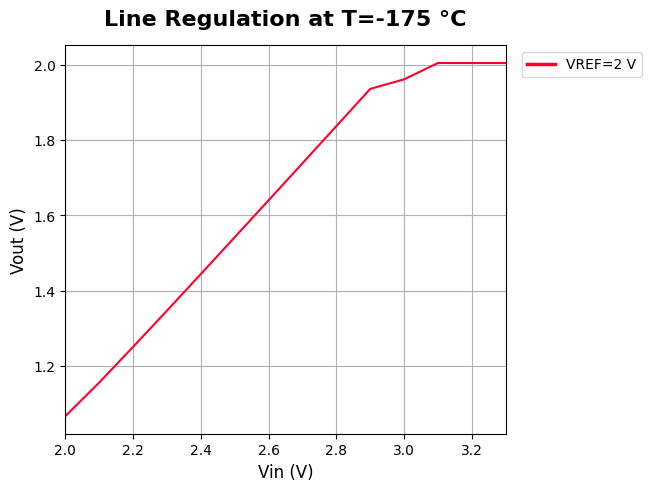

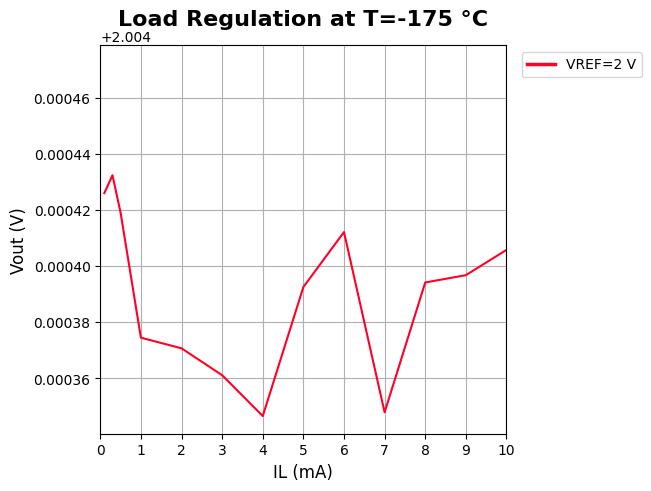

In [44]:
# Plotting from a CSV File
TEMPlist = [125, 100, 75, 50, 25,  0, -25, -50, -75, -100, -125, -150, -175]
ILlist = [100E-6, 300E-6, 500E-6, 1E-3, 2E-3, 3E-3, 4E-3, 5E-3, 6E-3, 7E-3, 8E-3, 9E-3, 10E-3]
ILlistmA= [num * 1000 for num in ILlist]
VREF = 2
VIN_MIN = 2
LineRfig, LineRplot = start_plot('Line Regulation at T=-175 °C', 'Vin (V)', 'Vout (V)')
new_MIN = max(VIN_MIN, VREF)
LineRplot.set_xticks(np.arange(new_MIN, 3.3, 0.2))
LineRplot.set_xlim(2, 3.3)

# Load regulation plot
LoadRfig, LoadRplot = start_plot('Load Regulation at T=-175 °C', 'IL (mA)', 'Vout (V)')
LoadRplot.set_xticks(np.arange(-1, 11, 1))
LoadRplot.set_xlim(0, ILlistmA[-1])

VIN_df = pd.read_csv(r"NPN_LVR_Results\2025-05-10\DUT_1\TEMP_-175\VIN_Sweep_VREF=2.0.csv")
IL_df = pd.read_csv(r"NPN_LVR_Results\2025-05-10\DUT_1\TEMP_-175\IL_Sweep_VREF=2.0.csv")

print(VIN_df)
print(IL_df)

ILlistc = [100E-6, 300E-6, 500E-6, 1E-3, 2E-3, 3E-3, 4E-3, 5E-3, 6E-3, 7E-3, 8E-3, 9E-3, 10E-3,1]
ILlistmAc = [num * 1000 for num in ILlistc]

LineRplot.plot(VIN_df['VIN'], VIN_df['VOUT'], label="VREF="+str(VREF)+" V")
LoadRplot.plot(ILlistmAc, IL_df['VOUT'], label="VREF="+str(VREF)+" V")

#Use these two lines to get rid of offset
#from matplotlib.ticker import ScalarFormatter
#LoadRplot.yaxis.set_major_formatter(ScalarFormatter(useOffset=False)) 

os.makedirs("tmp", exist_ok=True)
finish_plot(LineRplot, LineRfig, "tmp", "Line_Regulation_"+str(VREF)+"V.png", close=False)
finish_plot(LoadRplot, LoadRfig, "tmp", "Load_Regulation_"+str(VREF)+"V.png", close=False)

plt.show()

<h3> Changing my plotting function's defaults after calling it </h3>

    VIN      ITOT      VOUT     VDROP
0   3.3  0.003156  2.004321  1.019477
1   3.2  0.003146  2.004348  1.019479
2   3.1  0.003134  2.004458  1.019478
3   3.0  0.003114  1.961123  1.015305
4   2.9  0.002848  1.935660  1.019477
5   2.8  0.002546  1.837066  1.019516
6   2.7  0.002242  1.738515  1.019515
7   2.6  0.001939  1.640175  1.019498
8   2.5  0.001637  1.542123  1.019472
9   2.4  0.001336  1.444472  1.019486
10  2.3  0.001037  1.347287  1.019520
11  2.2  0.000740  1.251078  1.019523
12  2.1  0.000449  1.156481  1.019550
13  2.0  0.000173  1.067286  1.019569


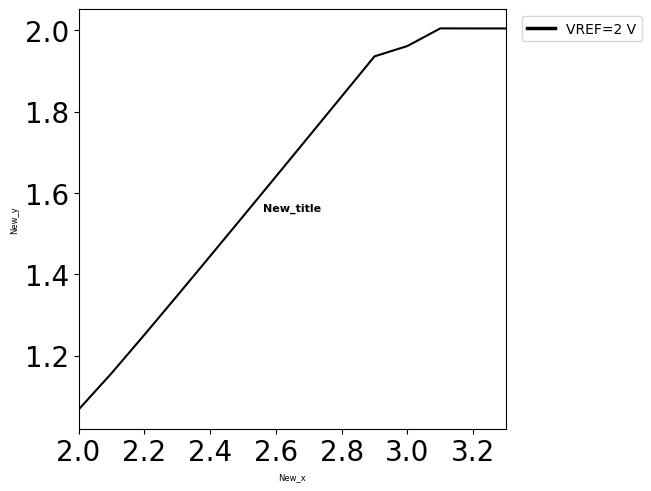

In [45]:
TEMPlist = [125, 100, 75, 50, 25,  0, -25, -50, -75, -100, -125, -150, -175]
VREF = 2
VIN_MIN = 2

# Default plot settings
LineRfig, LineRplot = start_plot('Line Regulation at T=-175 °C', 'Vin (V)', 'Vout (V)')
new_MIN = max(VIN_MIN, VREF)

# No defaults for these right now
LineRplot.set_xticks(np.arange(new_MIN, 3.3, 0.2))
LineRplot.set_xlim(2, 3.3)

# Changing defaults
LineRplot.set_title('New_title', fontdict={'fontsize': 8, 'fontweight': 'bold'}, y = .5)
LineRplot.set_xlabel('New_x', fontdict={'fontsize': 6})
LineRplot.set_ylabel('New_y', fontdict={'fontsize': 6})
LineRplot.tick_params(axis='both', which='major', labelsize=20)
cm_new = plt.get_cmap('copper')
LineRplot.set_prop_cycle ('color', [cm_new(1.*i/len(TEMPlist)) for i in range(len(TEMPlist))])
LineRplot.grid(False)

VIN_df = pd.read_csv(r"NPN_LVR_Results\2025-05-10\DUT_1\TEMP_-175\VIN_Sweep_VREF=2.0.csv")
print(VIN_df)
LineRplot.plot(VIN_df['VIN'], VIN_df['VOUT'], label="VREF="+str(VREF)+" V")

os.makedirs("tmp", exist_ok=True)
finish_plot(LineRplot, LineRfig, "tmp", "Line_Regulation_tmp_"+str(VREF)+"V.png", close=False)
plt.show()

# Yep, looks like you can change all of these. Good to know. 
# Obviously not the finish_plot() legend settings.

<h3> Adding Trailing Zeros to Filename Labels so they Sort Correctly </h3>

In [ ]:
# Adding trailing zeros
VREF = .6
print(f"VIN_Sweep_VREF={VREF}.csv")
print(f"VIN_Sweep_VREF={round(VREF, 2)}.csv")
print(f"VIN_Sweep_VREF={VREF:.2f}.csv")
# This makes files sort in the correct order. 
# Without it, .9 comes before .15, because Operating Systems will see 9 < 15
# Now they'll see 90 > 15, and it will be listed afterwards

VIN_Sweep_VREF=0.6.csv
VIN_Sweep_VREF=0.6.csv
VIN_Sweep_VREF=0.60.csv


<h3> Sun Chamber Wait Time </h3>

Results:\
It looks like the chamber saves the wait time when turned off and on. Perhaps the set too. Cool automatically turns on when the ON command is recieved, so need to watch out for that. (According to the manual, Heat too)\
The WAIT time doesn't start until SET is reached\
When WAIT runs out, it is automatically set to WAIT=FOREVER\
WAIT can also be set to FOREVER with CHAMBER.write("WAIT=FOREV")\
WAIT being set to FOREVER will initially allow one more SET command to go through, however, it will then stop CHAMBER.query("STATUS?")[3] == 'N' from realizing that the chamber has reached its desired temperature.

From the manual:\
The intended workflow for local programs (programmed with temperature chamber's buttons directly) is to call WAIT and then SET. The chamber climbs to the set value, then waits the specified amount of time. Then it moves on to the next set value in the script. To determine if the set time has been reached, the chamber checks if it is within a specified range, set by a "+/- Trigger" variable (which can be changed through the SDEF menu).\
The 4th (index=3) status bit specifies if wait_time is currently counting down.\
There is no way to directly utilize whatever internal function is checking if the probe temp is within the +/- Trigger range.

Past Code:\
We want our measuring equipment to decide the timing of the experiment. Past code up to the 5/29/25 PMOS_LDO has checked if the user probe temperature is close to the set value by leaving the wait timer always running, raising it whenever it gets low. After setting the temperature, code has been continually checking the 4th status bit to see if WAIT has started counting down, which occurs whenever the chamber internally checks the user probe against the +/- Trigger variable to see if it is within it.

Better approach:\
Easiest fix would be to only set WAIT before each SET, then to put it back to FOREVER after the value is reached. This would continue to use the chamber's internal checks.\
Perhaps the best fix would be to directly query the User probe temperature and then pass it to our own function that checks if it is within a range.

In [ ]:

CHAMBER = establish_connection('GPIB6::6::INSTR', 'STATUS?')
Chamber_INIT()

In [ ]:
TEMP = 30
CHAMBER.write("WAIT=3")                                # Resets the wait time of the temp chamber to 30 minutes so it doesn't time out mid test
CHAMBER.write("SET="+str(TEMP))
while (CHAMBER.query("STATUS?")[3] == 'N'):             # Checks if the temperature chamber has arrived at TEMP yet or not
    time.sleep(15)
    print(CHAMBER.query("STATUS?"))  
print(CHAMBER.query("STATUS?"))
time.sleep(65)

In [ ]:

CHAMBER = establish_connection('GPIB6::6::INSTR', 'STATUS?')
CHAMBER.write("ON")
CHAMBER.write("RATE=20")            # Sets the speed at which the chamber will ramp to change TEMP
CHAMBER.write("HON")                # Turns heat on
CHAMBER.write("PIDA=3")             
time.sleep(1) 

print(CHAMBER.query("RATE?"))
print(CHAMBER.query("WAIT?"))

NameError: name 'establish_connection' is not defined

In [ ]:
TEMP = 32
CHAMBER.write("WAIT=1")                                # Resets the wait time of the temp chamber to 30 minutes so it doesn't time out mid test
CHAMBER.write("SET="+str(TEMP))
while (CHAMBER.query("STATUS?")[3] == 'N'):             # Checks if the temperature chamber has arrived at TEMP yet or not
    time.sleep(15)
    print(CHAMBER.query("STATUS?"))  
print(CHAMBER.query("STATUS?"))
time.sleep(75)
TEMP = 33
#CHAMBER.write("WAIT=1")                                # Resets the wait time of the temp chamber to 30 minutes so it doesn't time out mid test
CHAMBER.write("SET="+str(TEMP))
while (CHAMBER.query("STATUS?")[3] == 'N'):             # Checks if the temperature chamber has arrived at TEMP yet or not
    time.sleep(15)
    print(CHAMBER.query("STATUS?"))  
print(CHAMBER.query("STATUS?"))

In [ ]:
TEMP = 32
#CHAMBER.write("WAIT=1")                                # Resets the wait time of the temp chamber to 30 minutes so it doesn't time out mid test
CHAMBER.write("SET="+str(TEMP))
while (CHAMBER.query("STATUS?")[3] == 'N'):             # Checks if the temperature chamber has arrived at TEMP yet or not
    time.sleep(15)
    print(CHAMBER.query("STATUS?"))  
print(CHAMBER.query("STATUS?"))
time.sleep(5)
TEMP = 33
#CHAMBER.write("WAIT=1")                                # Resets the wait time of the temp chamber to 30 minutes so it doesn't time out mid test
CHAMBER.write("SET="+str(TEMP))
while (CHAMBER.query("STATUS?")[3] == 'N'):             # Checks if the temperature chamber has arrived at TEMP yet or not
    time.sleep(15)
    print(CHAMBER.query("STATUS?"))  
print(CHAMBER.query("STATUS?"))

In [ ]:
TEMP = 33
CHAMBER.write("WAIT=30")                                # Resets the wait time of the temp chamber to 30 minutes so it doesn't time out mid test
CHAMBER.write("SET="+str(TEMP))
while (CHAMBER.query("STATUS?")[3] == 'N'):             # Checks if the temperature chamber has arrived at TEMP yet or not
    time.sleep(1)
    print(CHAMBER.query("STATUS?"))  
print(CHAMBER.query("STATUS?"))
time.sleep(10)
TEMP = 34
#CHAMBER.write("WAIT=1")                                # Resets the wait time of the temp chamber to 30 minutes so it doesn't time out mid test
CHAMBER.write("SET="+str(TEMP))
while (CHAMBER.query("STATUS?")[3] == 'N'):             # Checks if the temperature chamber has arrived at TEMP yet or not
    time.sleep(15)
    print(CHAMBER.query("STATUS?"))  
print(CHAMBER.query("STATUS?"))

In [ ]:
CHAMBER = establish_connection('GPIB6::6::INSTR', 'STATUS?')
CHAMBER.write("ON")
CHAMBER.write("RATE=20")            # Sets the speed at which the chamber will ramp to change TEMP
CHAMBER.write("HON")                # Turns heat on
CHAMBER.write("PIDA=3")             
CHAMBER.write("WAIT=FOREV")
time.sleep(1) 

print(CHAMBER.query("RATE?"))
print(CHAMBER.query("WAIT?"))

NameError: name 'establish_connection' is not defined

In [ ]:
TEMP = 32
#CHAMBER.write("WAIT=1")                                # Resets the wait time of the temp chamber to 30 minutes so it doesn't time out mid test
CHAMBER.write("SET="+str(TEMP))
while (CHAMBER.query("STATUS?")[3] == 'N'):             # Checks if the temperature chamber has arrived at TEMP yet or not
    time.sleep(15)
    print(CHAMBER.query("STATUS?"))  
print(CHAMBER.query("STATUS?"))
time.sleep(5)
TEMP = 33
#CHAMBER.write("WAIT=1")                                # Resets the wait time of the temp chamber to 30 minutes so it doesn't time out mid test
CHAMBER.write("SET="+str(TEMP))
while (CHAMBER.query("STATUS?")[3] == 'N'):             # Checks if the temperature chamber has arrived at TEMP yet or not
    time.sleep(15)
    print(CHAMBER.query("STATUS?"))  
print(CHAMBER.query("STATUS?"))

<h4> Solutions </h4>

In [10]:
CHAMBER = establish_connection('GPIB6::6::INSTR', 'STATUS?')
CHAMBER.write("ON")
CHAMBER.write("RATE=20")            # Sets the speed at which the chamber will ramp to change TEMP
CHAMBER.write("COFF")               # Turns cold off
CHAMBER.write("HON")                # Turns heat on
CHAMBER.write("PIDA=3")             
CHAMBER.write("WAIT=FOREV")
time.sleep(1) 

print(CHAMBER.query("RATE?"))
print(CHAMBER.query("WAIT?"))

GPIBInstrument at GPIB6::6::INSTR
NNNNNNNYNNNNNNNNNN0
+20.000
WAIT=FOREVER    


In [ ]:
# For some reason, even after changing wait to forever (and the chamber displaying it as such) the time out beep still sounded after 1 minute had elapsed. 
# Inconsistent behavior

TEMP = 18
CHAMBER.write("WAIT=1")
CHAMBER.write(f"SET={TEMP}")
while (CHAMBER.query("STATUS?")[3] == 'N'):  # Checks if the temperature chamber has arrived at TEMP yet or not
    time.sleep(10)
    print(CHAMBER.query("STATUS?"))
CHAMBER.write("WAIT=FOREV")
print(CHAMBER.query("STATUS?"))

YNNNYNYNNNNNNNNNNN0
YNNYYNYYNNNNNNNNNN0
YNNYYNYYNNNNNNNNNN0


In [ ]:
# Works great - we should do this always

TEMPS = [20, 21, 22]
SET_PRECISION = .15
for TEMP in TEMPS:
    CHAMBER.write(f"SET={TEMP}")
    while(True):
        time.sleep(10)
        user_probe_temp = CHAMBER.query("USER?")
        print(user_probe_temp)
        if ((float(user_probe_temp) < TEMP+SET_PRECISION) and (float(user_probe_temp) > TEMP-SET_PRECISION)):
            break
    print(CHAMBER.query("STATUS?"))

+19.657
+19.920
YNNNYNYYNNNNNNNNNN0
+20.61
+20.87
YNNNYNYYNNNNNNNNNN0
+21.52
+21.86
YNNNYNYYNNNNNNNNNN0
